In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from IPython.display import display

#%matplotlib notebook

import sys
import sklearn
#import pandas as pd
import matplotlib as mpl
#import matplotlib.pyplot as plt
import seaborn as sns

import re

%matplotlib inline

pd.options.display.max_rows = 10

### Зареждане и проверка на формата на данните:

In [4]:
multi = pd.read_csv('data/multipleChoiceResponses.csv', encoding='latin_1', low_memory=False)
free  = pd.read_csv('data/freeformResponses.csv', encoding='latin_1', low_memory=False)
print('multiple choice:', multi.shape)
print('free form:', free.shape)

multiple choice: (16716, 228)
free form: (16716, 62)


Ще започна с `multiple coice` данните, защото ми се вижда по-лесно.

### Наименования на колоните

In [5]:
multi.columns

Index(['GenderSelect', 'Country', 'Age', 'EmploymentStatus', 'StudentStatus',
       'LearningDataScience', 'CodeWriter', 'CareerSwitcher',
       'CurrentJobTitleSelect', 'TitleFit',
       ...
       'JobFactorExperienceLevel', 'JobFactorDepartment', 'JobFactorTitle',
       'JobFactorCompanyFunding', 'JobFactorImpact', 'JobFactorRemote',
       'JobFactorIndustry', 'JobFactorLeaderReputation', 'JobFactorDiversity',
       'JobFactorPublishingOpportunity'],
      dtype='object', length=228)

Всъщност имаме фаил с информация за колоните. Да не забравя, че тук може да се изпълняват bash команди.

In [6]:
!head data/schema.csv

schema.csv файла съдържа информация за:
 * наименованието на колоната използвано в другите файлове
 * въпроса зададен в анкетата, на който съответстват отговорите в данните
 * дали въпроса е за "множествен избор" или в свободна форма
 * дали въпроса е зададен на определена подгрупа респонденти

<a name="numeric_column_names"></a>Повечето от данните са категории а не числови 😣.

In [7]:
numeric_column_names = multi.describe().columns
print(numeric_column_names)

Index(['Age', 'LearningCategorySelftTaught', 'LearningCategoryOnlineCourses',
       'LearningCategoryWork', 'LearningCategoryUniversity',
       'LearningCategoryKaggle', 'LearningCategoryOther', 'TimeGatheringData',
       'TimeModelBuilding', 'TimeProduction', 'TimeVisualizing',
       'TimeFindingInsights', 'TimeOtherSelect'],
      dtype='object')


Колко празни са колоните с числови стойности? ([модел](#model))

In [8]:
for col in numeric_column_names:
    print(col, '# not NaNs:', sum(multi[col].isnull()))

Age # not NaNs: 331
LearningCategorySelftTaught # not NaNs: 3607
LearningCategoryOnlineCourses # not NaNs: 3590
LearningCategoryWork # not NaNs: 3605
LearningCategoryUniversity # not NaNs: 3594
LearningCategoryKaggle # not NaNs: 3590
LearningCategoryOther # not NaNs: 3622
TimeGatheringData # not NaNs: 9186
TimeModelBuilding # not NaNs: 9188
TimeProduction # not NaNs: 9199
TimeVisualizing # not NaNs: 9187
TimeFindingInsights # not NaNs: 9193
TimeOtherSelect # not NaNs: 9203


### Статистика на избрани колони:

#### Пол

In [9]:
print(multi.GenderSelect.value_counts())

Male                                                 13610
Female                                                2778
A different identity                                   159
Non-binary, genderqueer, or gender non-conforming       74
Name: GenderSelect, dtype: int64


Може и графгики:

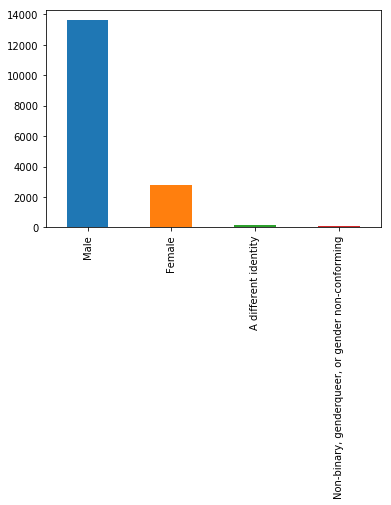

In [10]:
multi.GenderSelect.value_counts().plot(kind='bar');#, legend=True);

#### Държава:

In [11]:
print(multi.Country.value_counts())

United States     4197
India             2704
Other             1023
Russia             578
United Kingdom     535
                  ... 
Romania             59
Belarus             54
Norway              53
Czech Republic      53
Chile               51
Name: Country, Length: 52, dtype: int64


Целта на курса е догодина България да е в статистиката 😆

#### Възраст:

In [12]:
print(multi.Age.value_counts());

25.0    969
24.0    898
26.0    886
27.0    842
23.0    839
       ... 
83.0      1
94.0      1
10.0      1
82.0      1
9.0       1
Name: Age, Length: 84, dtype: int64


Интересно - точно десет от анкетираните са на 100 години 👴. Да видим и графично.

cannot convert float NaN to integer


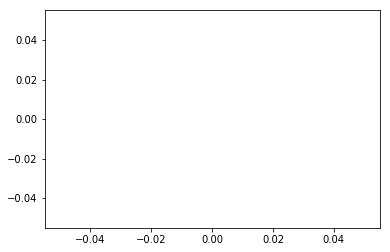

In [13]:
try:
    sns.distplot(multi.Age);
except ValueError as e:
    print(e)

Разбира се че ще има NaNs. Втори опит:

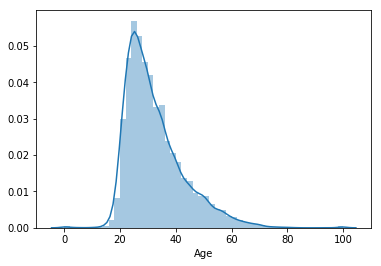

In [14]:
sns.distplot(multi.Age[multi.Age.notnull()]);

#### Заплати:

unsupported operand type(s) for /: 'str' and 'int'


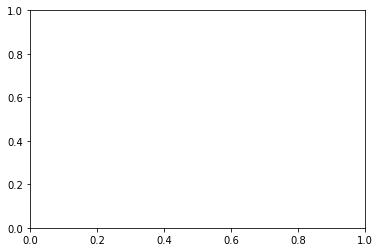

In [15]:
try:
    sns.distplot(multi.CompensationAmount[multi.CompensationAmount.notnull()]);
except TypeError as e:
    print(e)

Чудесно, сега и типа ще оправяме. След малко опити установих, че това е някаква легендарна структура, която миксира `float` за NaNs и `String` за числовите стойности:

In [16]:
multi[:20].CompensationAmount.apply(lambda x: print(x, type(x)));

nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
250,000 <class 'str'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
80000 <class 'str'>
1200000 <class 'str'>
nan <class 'float'>
95,000 <class 'str'>
nan <class 'float'>
nan <class 'float'>
1100000 <class 'str'>
120,000 <class 'str'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>


Следващия ред по принцип работи, но дава "FUTURE WARNING" 😕! (Отрязването [:0] е за да демонстрирам Warning-a без да печатам данните.)

In [17]:
multi[:0].CompensationAmount.convert_objects(convert_numeric=True)

/home/bob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


Series([], Name: CompensationAmount, dtype: object)

Ще пробвам да сменя типа по друг начин:

In [18]:
try:
    pd.to_numeric(multi.CompensationAmount, errors='raise')
except ValueError as e:
    print(e)

Unable to parse string "250,000" at position 3


Освен запетайка за хилядите, имаме още един чупещ символ - тире. Преди да презапишем в дата фрейма ще направим проверка.

In [19]:
temp = pd.to_numeric(multi.CompensationAmount.str.replace(',', '').replace('-', ''), errors='raise')
pd.DataFrame(data={'original': multi.CompensationAmount.iloc[10364:10374], 'new': temp[10364:10374]})

,new,original
10364,NaN,NaN
10365,NaN,-
10366,NaN,NaN
10367,NaN,NaN
10368,NaN,NaN
10369,NaN,NaN
10370,12000000.0,"12,000,000"
10371,NaN,NaN
10372,130000.0,130000
10373,90000.0,90000


Сега да омажем DataFrame-a

In [20]:
multi.CompensationAmount = pd.to_numeric(multi.CompensationAmount.str.replace(',', '').str.replace('-', ''), errors='raise')

Графика

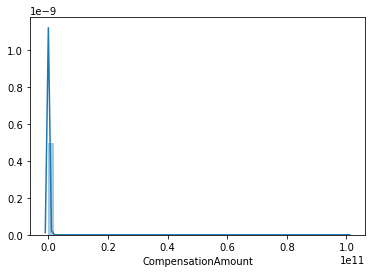

In [21]:
sns.distplot(multi.CompensationAmount[multi.CompensationAmount.notnull()]);

Я, някакви високи стойности изкривяват графиката.

In [22]:
compensation = pd.DataFrame(multi.CompensationAmount[multi.CompensationAmount.notnull()])
print(compensation.sort_values('CompensationAmount').head(5))
print(compensation.sort_values('CompensationAmount').tail(5))

       CompensationAmount
10525                 0.0
11978                 0.0
5960                  0.0
1693                  0.0
6420                  0.0
       CompensationAmount
9747         7.500000e+08
13418        8.000000e+08
5761         1.194000e+09
804          1.000000e+11
5458         1.000000e+11


Да видим дали превръщането към една валута ще помогне:

In [23]:
rates = pd.read_csv('data/conversionRates.csv', encoding='latin_1', low_memory=False)
rates[:10]

,Unnamed: 0,originCountry,exchangeRate
0,1,USD,1.000000
1,2,EUR,1.195826
2,3,INR,0.015620
3,4,GBP,1.324188
4,5,BRL,0.321350
5,6,RUB,0.017402
6,7,CAD,0.823688
7,8,AUD,0.802310
8,9,JPY,0.009108
9,10,CNY,0.153000


Искам да ползвам валутния код за индекс - за целта стойностите трябва да са уникални:

In [24]:
print('Има ли дупликати в originCountry?', all(rates.originCountry.duplicated()))

Има ли дупликати в originCountry? False


Тогава да сменим индекса:

In [25]:
rates = rates.set_index('originCountry')
print(rates.columns)

Index(['Unnamed: 0', 'exchangeRate'], dtype='object')


Да разкараме излишната колона:

In [26]:
rates = rates.drop('Unnamed: 0', axis=1)
rates[:10]

,exchangeRate
originCountry,
USD,1.000000
EUR,1.195826
INR,0.015620
GBP,1.324188
BRL,0.321350
RUB,0.017402
CAD,0.823688
AUD,0.802310
JPY,0.009108


Сега да проверим какви са данните за влутния код - има ли стойности в compensation за които липсва код

In [27]:
side_by_side = pd.DataFrame(data={'compensation': multi.CompensationAmount,
                                  'code': multi.CompensationCurrency})
print('общо данни:', len(side_by_side), '\nне-NaN compensation:',
      sum(side_by_side['compensation'].notnull()),
      '\nне-NaN compensation с валутен код NaN:',
      sum(side_by_side.code[side_by_side['compensation'].notnull()].isnull()))

some_partial_df = side_by_side.code[side_by_side['compensation'].notnull()]
another_partial_df = some_partial_df[some_partial_df.notnull()]
print('ползваеми данни:', len(another_partial_df))
# another_partial_df

общо данни: 16716 
не-NaN compensation: 5217 
не-NaN compensation с валутен код NaN: 843
ползваеми данни: 4374


Тъй като искам само да видя нормална графика, няма да бутам основния дата фрейм а ще си направя нов, който съдържа само данните с които ще чартая.

In [28]:
plotable_compensation = multi.dropna(axis=0, subset=['CompensationCurrency', 'CompensationAmount'])
plotable_compensation

,GenderSelect,Country,Age,EmploymentStatus,StudentStatus,LearningDataScience,CodeWriter,CareerSwitcher,CurrentJobTitleSelect,TitleFit,...,JobFactorExperienceLevel,JobFactorDepartment,JobFactorTitle,JobFactorCompanyFunding,JobFactorImpact,JobFactorRemote,JobFactorIndustry,JobFactorLeaderReputation,JobFactorDiversity,JobFactorPublishingOpportunity
3,Male,United States,56.0,"Independent contractor, freelancer, or self-em...",NaN,NaN,Yes,NaN,Operations Research Practitioner,Poorly,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Female,Australia,43.0,Employed full-time,NaN,NaN,Yes,NaN,Business Analyst,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Male,Russia,33.0,Employed full-time,NaN,NaN,Yes,NaN,Software Developer/Software Engineer,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Male,India,27.0,Employed full-time,NaN,NaN,Yes,NaN,Data Scientist,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,Male,Taiwan,26.0,Employed full-time,NaN,NaN,Yes,NaN,Software Developer/Software Engineer,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,Male,Other,56.0,Employed full-time,NaN,NaN,Yes,NaN,DBA/Database Engineer,Poorly,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16517,Male,Germany,34.0,Employed full-time,NaN,NaN,Yes,NaN,Software Developer/Software Engineer,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16525,Male,United States,50.0,Employed full-time,NaN,NaN,Yes,NaN,Data Scientist,Perfectly,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16577,Male,Norway,32.0,Employed full-time,NaN,NaN,Yes,NaN,Data Analyst,Perfectly,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Да калкулираме компенсацията в USD:

In [29]:
try:
    plotable_compensation['compensation'] = plotable_compensation.apply(lambda row:
        row['CompensationAmount'] * rates.loc[row['CompensationCurrency']], axis=1)
except KeyError as e:
    print(e)

('the label [SPL] is not in the [index]', 'occurred at index 12623')


Разбира се че ще има нечия заплата дадена в [Себоргийско](https://bg.wikipedia.org/wiki/%D0%A1%D0%B5%D0%B1%D0%BE%D1%80%D0%B3%D0%B0) Луиджино, а други изненади има ли?

In [30]:
set(plotable_compensation.CompensationCurrency.unique()) - set(rates.index)

{'SPL'}

Просто ще го добавим - проверих курса USD/SPL = 6

In [31]:
rates.loc['SPL'] = 6.0
print('Валути използвани в multipleChoiceResponses.csv, но липсващи в conversionRates.csv:',\
      list(set(plotable_compensation.CompensationCurrency.unique()) - set(rates.index)))

Валути използвани в multipleChoiceResponses.csv, но липсващи в conversionRates.csv: []


Пореден опит за калкулираме компенсацията в USD:

In [32]:
plotable_compensation['compensation'] = plotable_compensation.apply(
    lambda row: row['CompensationAmount'] * rates.loc[row['CompensationCurrency']], axis=1)
plotable_compensation.compensation

/home/bob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


3        250000.000
8         64184.800
9         20882.400
11         1483.900
14        36634.400
            ...    
16507     50000.000
16517    100449.384
16525    200000.000
16577     89686.950
16700     10000.000
Name: compensation, Length: 4374, dtype: float64

Мина. Да видим графиката:

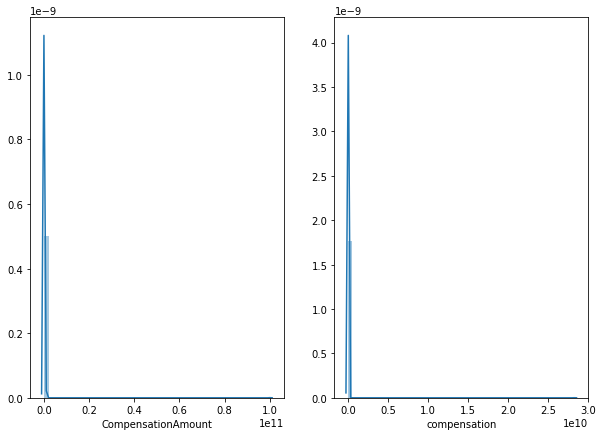

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7), sharey=False)
sns.distplot(compensation.CompensationAmount, ax=axes[0])
sns.distplot(plotable_compensation.compensation, ax=axes[1]);

Явно корекцията от валутния курс не е достатъчна. Да видим данните - какви са тия милиони?

In [34]:
pd.options.display.max_rows = 20
pd.set_option('display.float_format', '{:.2f}'.format)

selected = plotable_compensation.sort_values('compensation', ascending=False)[['CompensationAmount',
                                    'compensation', 'CompensationCurrency', 'Country']]
selected.head(20)

,CompensationAmount,compensation,CompensationCurrency,Country
5458,100000000000.00,28297400000.00,ILS,United Kingdom
804,100000000000.00,209000000.00,AMD,United States
3013,9999999.00,9999999.00,USD,People 's Republic of China
15678,14000000.00,4498900.00,BRL,Brazil
12531,2500000.00,2500000.00,USD,United States
4481,2400000.00,2395468.80,BSD,Other
12808,2000000.00,2000000.00,USD,United Kingdom
11970,25000000.00,1059875.00,ETB,Other
8880,1000000.00,1000000.00,USD,Taiwan
1514,1000000.00,1000000.00,USD,United States


Не можах да излъжа Pandas, хем да ми форматира числата без научна нотация, хем да маркира с цвят. Плзването на highlight изглежда ресет-ва формата на нотацията. 

In [35]:
# pd.reset_option('display.float_format')
selected[:20].style.apply(lambda x:
                     ['background: lightblue' if x.name == 'compensation' and
                      isinstance(z, float) and z >= 1e+06 else
                      '' for i,z in x.iteritems()])

,CompensationAmount,compensation,CompensationCurrency,Country
5458,1e+11,2.82974e+10,ILS,United Kingdom
804,1e+11,2.09e+08,AMD,United States
3013,1e+07,1e+07,USD,People 's Republic of China
15678,1.4e+07,4.4989e+06,BRL,Brazil
12531,2.5e+06,2.5e+06,USD,United States
4481,2.4e+06,2.39547e+06,BSD,Other
12808,2e+06,2e+06,USD,United Kingdom
11970,2.5e+07,1.05988e+06,ETB,Other
8880,1e+06,1e+06,USD,Taiwan
1514,1e+06,1e+06,USD,United States


ОК, тия с най-големите суми са очевидни тролове, останалите с милион и на горе са допуснали техническа грешка при броя на нулите.

In [36]:
# selected.drop((selected['compensation'] >= 1e+7).index, inplace=True)
# selected
rows_to_delete = selected[selected['compensation'] >= 1e+6].index
print('редове за премахване:', rows_to_delete)
selected.drop(rows_to_delete, inplace=True)
selected[:20].style.apply(lambda x: ['background: lightgreen' if x.name == 'compensation' and isinstance(z, float) and z >= 400000 else '' for i,z in x.iteritems()])

редове за премахване: Int64Index([5458, 804, 3013, 15678, 12531, 4481, 12808, 11970, 8880, 1514, 993,
            11689],
           dtype='int64')


,CompensationAmount,compensation,CompensationCurrency,Country
10601,7e+06,699090,VEF,Other
12623,115000,690000,SPL,United States
2538,450000,595885,GBP,United Kingdom
15494,550000,550000,USD,United States
9224,500000,500000,USD,United States
419,470000,470000,USD,United States
9206,3e+06,459000,CNY,People 's Republic of China
6357,400000,400000,USD,United States
6301,400000,400000,USD,Australia
3743,400000,400000,USD,Other


Да видим графиката:

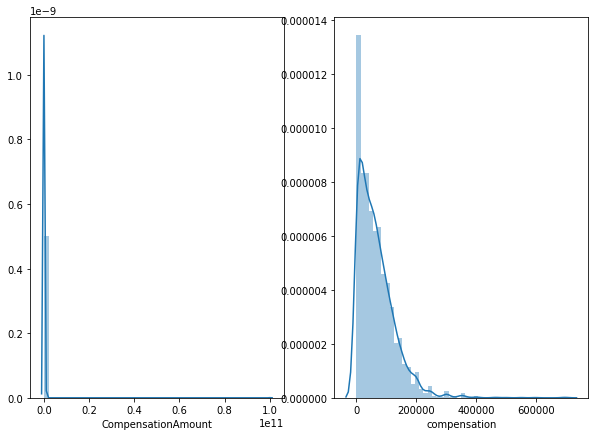

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7), sharey=False)
sns.distplot(compensation.CompensationAmount, ax=axes[0])
sns.distplot(selected.compensation, ax=axes[1]);

Така е по-добре.

#### Платформа за обучение:

In [38]:
pd.options.display.max_rows = 20
multi.LearningPlatformSelect

0        College/University,Conferences,Podcasts,Trade ...
1                                                   Kaggle
2        Arxiv,College/University,Kaggle,Online courses...
3        Blogs,College/University,Conferences,Friends n...
4                        Arxiv,Conferences,Kaggle,Textbook
5        Kaggle,Online courses,Stack Overflow Q&A,Textbook
6            Arxiv,Blogs,Kaggle,Personal Projects,Textbook
7        College/University,Kaggle,Online courses,Stack...
8        Blogs,Company internal community,Conferences,F...
9        Arxiv,Blogs,Conferences,Kaggle,Non-Kaggle onli...
                               ...                        
16706                                                  NaN
16707                                                  NaN
16708                                                  NaN
16709                                                  NaN
16710                                                  NaN
16711                                                  N

In [39]:
pd.options.display.max_rows = 10

`DataFrame` обекти се форматират в таблици - така е по-четимо.

In [40]:
pd.DataFrame(multi.LearningPlatformSelect.value_counts())

,LearningPlatformSelect
Kaggle,210
Online courses,209
Personal Projects,155
College/University,127
YouTube Videos,127
...,...
"Blogs,Friends network,Online courses,Trade book,YouTube Videos",1
"Arxiv,Blogs,Kaggle,Non-Kaggle online communities,Personal Projects,Textbook",1
"Arxiv,Conferences,Stack Overflow Q&A,YouTube Videos",1
"Blogs,Conferences,Friends network,Kaggle,Official documentation,Online courses,Podcasts,Stack Overflow Q&A,Textbook",1


Ясно е, че отговорите на въпроса са конкатанирани в стринг и ще трябва да се разбият на отделни колони. За целта първо ще зачистим NaNs.

In [41]:
multi['LearningPlatformSelect'] = multi['LearningPlatformSelect'].fillna('')
multi.LearningPlatformSelect

0        College/University,Conferences,Podcasts,Trade ...
1                                                   Kaggle
2        Arxiv,College/University,Kaggle,Online courses...
3        Blogs,College/University,Conferences,Friends n...
4                        Arxiv,Conferences,Kaggle,Textbook
                               ...                        
16711                                                     
16712    Kaggle,Non-Kaggle online communities,Online co...
16713                                                     
16714                                                     
16715                                                     
Name: LearningPlatformSelect, Length: 16716, dtype: object

Да съберем речник от възможните стойности:

In [42]:
accumulator = set([])
multi.apply(lambda row: accumulator.update(set(row['LearningPlatformSelect'].split(','))), axis=1)
accumulator = accumulator - set([''])
print('Брой платформи:',len(accumulator))
print(accumulator)

Брой платформи: 19
{'Podcasts', 'Tutoring/mentoring', 'Kaggle', 'Blogs', 'Online courses', 'YouTube Videos', 'Newsletters', 'Textbook', 'Official documentation', 'Personal Projects', 'Stack Overflow Q&A', 'College/University', 'Friends network', 'Non-Kaggle online communities', 'Other', 'Arxiv', 'Trade book', 'Company internal community', 'Conferences'}


Имам чувството, че този фичър няма да е единствения, при който ще е нужно подобно преформатиране. Затова ще си напиша процедура. (вариант с scikit-learn трансформер ще пробвам в следващия notebook)

In [43]:
def TextToOneHot(source_df, target_feature, categories=None,\
                 separator=',', fillna='NA', drop_target_at_fin=False):
    # Returns new DataFrame with OneHotEncoding of Categories
    #    extracted from the text of the target feature.
    
    # backup the data
    df = source_df.copy()
    
    # clear NaNs
    df[target_feature] = df[target_feature].fillna(fillna)
    
    # extract categories, if not provided
    if not categories:
        categories = set([])
        df.apply(lambda row: categories.update(set(row[target_feature].split(separator))), axis=1)
        
    # loop the categories and map to new features
    pattern = re.compile('[\W]+')
    for category in categories:
        new_feature_name = target_feature + '_' + category.replace(' ', '_')
        new_feature_name = pattern.sub('', new_feature_name)
        df[new_feature_name] = df.apply(lambda row: float(bool(row[target_feature].count(category))), axis=1)
    
    if drop_target_at_fin:
        df.drop(target_feature, axis=1, inplace=True)
    
    return df


Първо ще тествам с откъс от данните - приготвям dummy_df:

In [44]:
dummy_data = [
    ["Dataset aggregator/platform (i.e. Socrata/Kaggle Datasets/data.world/etc.)",
    "Arxiv,College/University,Kaggle,Online courses,YouTube Videos", "Very useful"],
    ["GitHub", "Arxiv,Conferences,Kaggle,Textbook", "Very useful"],
    ["Dataset aggregator/platform (i.e. Socrata/Kaggle Datasets/data.world/etc.)",
    "Arxiv,Blogs,Kaggle,Personal Projects,Textbook", "Somewhat useful"],
    ["I collect my own data (e.g. web-scraping)",
    "Arxiv,Blogs,Conferences,Kaggle,Non-Kaggle online communities,Official documentation,Online courses,\
    Personal Projects,Podcasts,Stack Overflow Q&A,Textbook,YouTube Videos",
    "Somewhat useful"],
    ["Dataset aggregator/platform (i.e. Socrata/Kaggle Datasets/data.world/etc.)",
    "Arxiv,College/University,Kaggle,Stack Overflow Q&A,Textbook,Tutoring/mentoring",
    "Somewhat useful"],
    ["Dataset aggregator/platform (i.e. Socrata/Kaggle Datasets/data.world/etc.)",
    "Arxiv,Blogs,Company internal community,Conferences,Kaggle,Non-Kaggle online communities,Personal Projects,\
    Podcasts,Stack Overflow Q&A,Textbook,YouTube Videos", "Very useful"],
    ["Google Search", "Arxiv,Blogs,College/University,Company internal community,Conferences,Kaggle,Newsletters,\
    Non-Kaggle online communities,Official documentation,Online courses,Personal Projects,Podcasts,\
    Stack Overflow Q&A,Textbook,Trade book,Tutoring/mentoring,YouTube Videos", "Very useful"],
    ["I collect my own data (e.g. web-scraping)",
    "Arxiv,Blogs,Kaggle,Online courses,Personal Projects,Stack Overflow Q&A,YouTube Videos", "Very useful"],
    ["University/Non-profit research group websites",
    "Arxiv,Blogs,College/University,Conferences,Kaggle,Non-Kaggle online communities,Official documentation,\
    Stack Overflow Q&A", "Very useful"],
    ["Dataset aggregator/platform (i.e. Socrata/Kaggle Datasets/data.world/etc.)",
    "Arxiv,Blogs,College/University,Kaggle,Newsletters,Stack Overflow Q&A,YouTube Videos", "Very useful"],
    ["Dataset aggregator/platform (i.e. Socrata/Kaggle Datasets/data.world/etc.)",
    "Arxiv,Blogs,College/University,Company internal community,Friends network,Kaggle,\
    Non-Kaggle online communities,Official documentation,Online courses,Personal Projects,\
    Stack Overflow Q&A,Textbook,YouTube Videos", "Somewhat useful"],
    ["University/Non-profit research group websites",
    "Arxiv,Kaggle,Official documentation,Online courses,Stack Overflow Q&A,YouTube Videos", "Somewhat useful"],
    ["Dataset aggregator/platform (i.e. Socrata/Kaggle Datasets/data.world/etc.)",
    "Arxiv,Blogs,Conferences,Kaggle,Non-Kaggle online communities", "Very useful"]
]

dummy_df = pd.DataFrame(data=dummy_data)
dummy_df.columns = ['PersonalProjectsChallengeFreeForm','LearningPlatformSelect','LearningPlatformCommunityFreeForm']

# adding NaN to make it more realistic
dummy_df['LearningPlatformSelect'][8] = None
dummy_df

,PersonalProjectsChallengeFreeForm,LearningPlatformSelect,LearningPlatformCommunityFreeForm
0,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,College/University,Kaggle,Online courses...",Very useful
1,GitHub,"Arxiv,Conferences,Kaggle,Textbook",Very useful
2,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,Blogs,Kaggle,Personal Projects,Textbook",Somewhat useful
3,I collect my own data (e.g. web-scraping),"Arxiv,Blogs,Conferences,Kaggle,Non-Kaggle onli...",Somewhat useful
4,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,College/University,Kaggle,Stack Overflow...",Somewhat useful
...,...,...,...
8,University/Non-profit research group websites,None,Very useful
9,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,Blogs,College/University,Kaggle,Newslett...",Very useful
10,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,Blogs,College/University,Company interna...",Somewhat useful
11,University/Non-profit research group websites,"Arxiv,Kaggle,Official documentation,Online cou...",Somewhat useful


Прилагаме процедурата за енкодинг и получаваме една камара колони:

In [45]:
new_df = TextToOneHot(dummy_df, 'LearningPlatformSelect')
new_df

,PersonalProjectsChallengeFreeForm,LearningPlatformSelect,LearningPlatformCommunityFreeForm,LearningPlatformSelect_Podcasts,LearningPlatformSelect_Tutoringmentoring,LearningPlatformSelect_Kaggle,LearningPlatformSelect_Blogs,LearningPlatformSelect_Online_courses,LearningPlatformSelect_YouTube_Videos,LearningPlatformSelect_Newsletters,...,LearningPlatformSelect_____Stack_Overflow_QA,LearningPlatformSelect_Stack_Overflow_QA,LearningPlatformSelect_CollegeUniversity,LearningPlatformSelect_Friends_network,LearningPlatformSelect_NonKaggle_online_communities,LearningPlatformSelect_Arxiv,LearningPlatformSelect_Trade_book,LearningPlatformSelect_Company_internal_community,LearningPlatformSelect_Conferences,LearningPlatformSelect_____NonKaggle_online_communities
0,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,College/University,Kaggle,Online courses...",Very useful,0.00,0.00,1.00,0.00,1.00,1.00,0.00,...,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
1,GitHub,"Arxiv,Conferences,Kaggle,Textbook",Very useful,0.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
2,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,Blogs,Kaggle,Personal Projects,Textbook",Somewhat useful,0.00,0.00,1.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
3,I collect my own data (e.g. web-scraping),"Arxiv,Blogs,Conferences,Kaggle,Non-Kaggle onli...",Somewhat useful,1.00,0.00,1.00,1.00,1.00,1.00,0.00,...,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00
4,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,College/University,Kaggle,Stack Overflow...",Somewhat useful,0.00,1.00,1.00,0.00,0.00,0.00,0.00,...,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,University/Non-profit research group websites,NA,Very useful,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,Blogs,College/University,Kaggle,Newslett...",Very useful,0.00,0.00,1.00,1.00,0.00,1.00,1.00,...,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
10,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,Blogs,College/University,Company interna...",Somewhat useful,0.00,0.00,1.00,1.00,1.00,1.00,0.00,...,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00,1.00
11,University/Non-profit research group websites,"Arxiv,Kaggle,Official documentation,Online cou...",Somewhat useful,0.00,0.00,1.00,0.00,1.00,1.00,0.00,...,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00


Бъркане по колоните на сляпо е доста безполезно. Преди да избера друг подход трябва да си определя цел:
 * да изследвам определени отношения между характеристики - например:
    * има ли зависимост между пол и заплата (Compensation)
 * да тренирам конкретен модел - например:
    * предсказване на Compensation въз основа на избрани характеристики възраст и държава
    * предсказване на Compensation въз основа на всички multipleChoice характеристики
    * предсказване на Compensation въз основа на multipleChoice + Freeform характеристики
    
Предполагам, че ще потренирам по избрани характеристики. Ако е нужно лесно могат да се добавят други характеристики в последствие. 

### Моделиране<a name="model"></a>

#### Подбор на данните

Реших, че е най-интересно да моделирам Compensation въз основа на избрани характеристики, като възраст, държава и др.





Първо да извадим избраните колони в нови DataFrame-и x & y.

In [187]:
x = pd.DataFrame(data={'Sex': multi.GenderSelect, 'Age': multi.Age, 'Country': multi.Country, 'Job': multi.CurrentJobTitleSelect, 'Platform': multi.LearningPlatformSelect})
x

,Age,Country,Job,Platform,Sex
0,nan,NaN,DBA/Database Engineer,"College/University,Conferences,Podcasts,Trade ...","Non-binary, genderqueer, or gender non-conforming"
1,30.00,United States,NaN,Kaggle,Female
2,28.00,Canada,NaN,"Arxiv,College/University,Kaggle,Online courses...",Male
3,56.00,United States,Operations Research Practitioner,"Blogs,College/University,Conferences,Friends n...",Male
4,38.00,Taiwan,Computer Scientist,"Arxiv,Conferences,Kaggle,Textbook",Male
...,...,...,...,...,...
16711,24.00,Other,NaN,,Female
16712,25.00,Indonesia,Programmer,"Kaggle,Non-Kaggle online communities,Online co...",Male
16713,25.00,Taiwan,NaN,,Female
16714,16.00,Singapore,NaN,,Female


In [188]:
for col in x.columns:
    print(col, 'брой NaN:', sum(x[col].isnull()) )

Age брой NaN: 331
Country брой NaN: 121
Job брой NaN: 4886
Platform брой NaN: 0
Sex брой NaN: 95


За Y ще ползваме вече обработената колона 'compensation' в която компенсацията е сметната в USD. Тя в наивно именования датасет 'plotable_compensation'.

In [189]:
y = pd.DataFrame(data={'Compensation': plotable_compensation.compensation})
y

,Compensation
3,250000.00
8,64184.80
9,20882.40
11,1483.90
14,36634.40
...,...
16507,50000.00
16517,100449.38
16525,200000.00
16577,89686.95


Опа, тук сме затрили редовете с NaN стойности, та "формите" на датасетовете x & y не съвпадат:

In [190]:
print('x: ', x.shape)
print('y: ', y.shape)

x:  (16716, 5)
y:  (4374, 1)


Тъй като индексите на у са запазени, можем да затрием съответните редове от х:

In [191]:
x = x.reindex(y.index)
print('x: ', x.shape)
print('y: ', y.shape)

x:  (4374, 5)
y:  (4374, 1)


Да нацепим💪 данните на тренировачни и тестови:

In [192]:
from sklearn.model_selection import train_test_split

# %reset_selective -f [xy]_t....?

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.3,
                                                    random_state=1337)

[ print(z.shape) for z in [x_train, x_test, y_train, y_test] ];

(3061, 5)
(1313, 5)
(3061, 1)
(1313, 1)


Въпрос - трябваше ли да разделя данните преди да зачистя NaN записите от у? Аз поне не виждам причина. 

Този път ще ползвам **CountVectorizer** за да хвана уникалните стойности за категорията Platform. 

In [193]:
from sklearn.feature_extraction.text import CountVectorizer

# cv = CountVectorizer(token_pattern=r'(?<=(,|\A))[^,"]+?(?=[,$])')
# cv = CountVectorizer(token_pattern=r'(?<=(,|^))[^,"]+?(?=[,$])')
cv = CountVectorizer(token_pattern=r'[^,]+')

cv.fit(x_train.Platform)
print('Намерени категории:', len(cv.get_feature_names()))
cv.get_feature_names()

Намерени категории: 19


['arxiv',
 'blogs',
 'college/university',
 'company internal community',
 'conferences',
 'friends network',
 'kaggle',
 'newsletters',
 'non-kaggle online communities',
 'official documentation',
 'online courses',
 'other',
 'personal projects',
 'podcasts',
 'stack overflow q&a',
 'textbook',
 'trade book',
 'tutoring/mentoring',
 'youtube videos']

Каква е разликата между **.vocabulary_.items()** и **.get_feature_names()**

In [194]:
set(cv.get_feature_names()) - set(cv.vocabulary_.keys())

set()

Проверка на резултатите спрямо предишния речник.

In [195]:
cv.vocabulary_.items()
set([ z.lower() for z in accumulator]) - set(cv.vocabulary_.keys())

set()

In [196]:
encoded_platforms_matrix = cv.fit_transform(x_train.Platform)
print(encoded_platforms_matrix[:20].todense())

[[0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1]
 [0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1]
 [1 1 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1]
 [1 1 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1]
 [0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0]
 [0 1 1 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0]
 [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1]
 [0 1 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 1]
 [1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0]
 [1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1]
 [0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 0]
 [0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0]
 [1 0 1 0 0 0 1 0 0 0 1 0 1 1 1 1 0 0 0]
 [0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0]]


In [200]:
encoded_platforms = pd.DataFrame(data=encoded_platforms_matrix.todense(), index=x_train.index, columns=cv.get_feature_names())
encoded_platforms

,arxiv,blogs,college/university,company internal community,conferences,friends network,kaggle,newsletters,non-kaggle online communities,official documentation,online courses,other,personal projects,podcasts,stack overflow q&a,textbook,trade book,tutoring/mentoring,youtube videos
8416,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
3587,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1
11542,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
5581,1,1,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,1
16134,1,1,1,0,1,0,1,0,0,1,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10424,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0
3547,0,1,1,0,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0
2598,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1
728,1,1,1,0,1,1,1,0,0,0,0,0,0,0,1,0,0,1,0


In [198]:
x_train.iloc[0].Platform

'Blogs,Kaggle,Online courses,Stack Overflow Q&A,YouTube Videos'

In [199]:
x_train

,Age,Country,Job,Platform,Sex
8416,27.00,Israel,Scientist/Researcher,"Blogs,Kaggle,Online courses,Stack Overflow Q&A...",Female
3587,56.00,United States,Statistician,"Company internal community,Online courses,Pers...",Male
11542,35.00,Other,Data Scientist,"Blogs,College/University,Kaggle,Online courses...",Male
5581,34.00,United States,Other,"Arxiv,Blogs,Company internal community,Confere...",Male
16134,29.00,Romania,Researcher,"Arxiv,Blogs,College/University,Conferences,Kag...",Female
...,...,...,...,...,...
10424,31.00,Chile,Data Scientist,"Official documentation,Online courses,Stack Ov...",Female
3547,26.00,Mexico,Computer Scientist,"Blogs,College/University,Conferences,Friends n...",Male
2598,43.00,South Africa,Data Scientist,"Arxiv,Company internal community,Conferences,K...",Male
728,25.00,United States,Scientist/Researcher,"Arxiv,Blogs,College/University,Conferences,Fri...",Male


In [201]:
concatenated = pd.concat([x_train, encoded_platforms], axis=1)
concatenated

,Age,Country,Job,Platform,Sex,arxiv,blogs,college/university,company internal community,conferences,...,official documentation,online courses,other,personal projects,podcasts,stack overflow q&a,textbook,trade book,tutoring/mentoring,youtube videos
8416,27.00,Israel,Scientist/Researcher,"Blogs,Kaggle,Online courses,Stack Overflow Q&A...",Female,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
3587,56.00,United States,Statistician,"Company internal community,Online courses,Pers...",Male,0,0,0,1,0,...,0,1,0,1,0,0,1,0,0,1
11542,35.00,Other,Data Scientist,"Blogs,College/University,Kaggle,Online courses...",Male,0,1,1,0,0,...,0,1,0,0,0,1,0,0,0,1
5581,34.00,United States,Other,"Arxiv,Blogs,Company internal community,Confere...",Male,1,1,0,1,1,...,0,1,0,0,1,0,1,0,1,1
16134,29.00,Romania,Researcher,"Arxiv,Blogs,College/University,Conferences,Kag...",Female,1,1,1,0,1,...,1,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10424,31.00,Chile,Data Scientist,"Official documentation,Online courses,Stack Ov...",Female,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0
3547,26.00,Mexico,Computer Scientist,"Blogs,College/University,Conferences,Friends n...",Male,0,1,1,0,1,...,0,0,0,1,1,1,0,0,0,0
2598,43.00,South Africa,Data Scientist,"Arxiv,Company internal community,Conferences,K...",Male,1,0,0,1,1,...,0,0,0,0,0,1,0,0,0,1
728,25.00,United States,Scientist/Researcher,"Arxiv,Blogs,College/University,Conferences,Fri...",Male,1,1,1,0,1,...,0,0,0,0,0,1,0,0,1,0


In [206]:
x_train = concatenated.drop(['Platform'], axis=1)
x_train

,Age,Country,Job,Sex,arxiv,blogs,college/university,company internal community,conferences,friends network,...,official documentation,online courses,other,personal projects,podcasts,stack overflow q&a,textbook,trade book,tutoring/mentoring,youtube videos
8416,27.00,Israel,Scientist/Researcher,Female,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
3587,56.00,United States,Statistician,Male,0,0,0,1,0,0,...,0,1,0,1,0,0,1,0,0,1
11542,35.00,Other,Data Scientist,Male,0,1,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
5581,34.00,United States,Other,Male,1,1,0,1,1,0,...,0,1,0,0,1,0,1,0,1,1
16134,29.00,Romania,Researcher,Female,1,1,1,0,1,0,...,1,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10424,31.00,Chile,Data Scientist,Female,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0
3547,26.00,Mexico,Computer Scientist,Male,0,1,1,0,1,1,...,0,0,0,1,1,1,0,0,0,0
2598,43.00,South Africa,Data Scientist,Male,1,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,1
728,25.00,United States,Scientist/Researcher,Male,1,1,1,0,1,1,...,0,0,0,0,0,1,0,0,1,0


Пфффу. Останалите може директно с OneHot. 

In [220]:
from sklearn.preprocessing import OneHotEncoder

try:
    tmp = OneHotEncoder().fit(x_train)
    tmp
except ValueError as e:
    print(e)

could not convert string to float: 'Male'


Трябва ли да фейл-на една регресия преди да си оправя данните?

In [ ]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
try:
    regressor.fit(x_train, y_train)
except ValueError as e:
    print(e)
    
try:
    regressor.fit(x_train, y_train)
except ValueError as e:
    print(e)

In [ ]:
for feature in ['Age', 'ProdTime']:
    print('брой нулеви записи за', feature, ' :',
          len(x_train[feature]) - len(x_train[feature].nonzero()[0]))
for feature in ['Age', 'ProdTime']:
    print('брой NaN записи за', feature, ' :', x_train[feature].isnull().sum())

In [ ]:
x_train['Age'] = x_train['Age'].fillna(x_train['Age'].mean())
x_train['ProdTime'] = x_train['ProdTime'].fillna(0)

In [ ]:
regressor.fit(x_train[['Age', 'ProdTime']], y_train)

In [ ]:
regressor.score(x_train[['Age', 'ProdTime']], y_train)

In [ ]:
allpoints = pd.DataFrame(data={'age': x_train['Age'], 'Money': y_train['Compensation']})
print(allpoints.shape)
print(allpoints.columns)
print(y_train.columns)
print(allpoints.Money[:10])
sns.set()
g = sns.PairGrid(allpoints)
g = g.map(plt.scatter)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

threedee = plt.figure(figsize=(10, 10)).gca(projection='3d')
threedee.scatter( x_train['Age'], x_train['ProdTime'], y_train)
threedee.set_xlabel('Age')
threedee.set_ylabel('Time')
threedee.set_zlabel('$')
plt.show()

Как е на български outliers?

In [ ]:
allpoints.sort_values('Money', ascending=False)

In [ ]:
for column in x_train.columns:
    print(column, 'len:', len(x_train.index),
          '; nonzero:', len(x_train[column].nonzero()[0]),
          '; isnull:', len(x_train[column].isnull()) )

DELME---- -- - Разликата за nonzero е ОК, въпроса е да няма NaN. Y няма да го проверявам за NaN, защото вече филтрирахме само записите с данни. Все пак може да има нулеви стойности:


    print('брой нулеви записи:', len(y_train) - len(y_train.Compensation.nonzero()[0]))
    print(len(y_train))
    print(len(y_train.Compensation.nonzero()[0]))

----- --- ------


От не-цифровите полета, само Platform е текст от изброени категории, останалите - Job, Country & Sex - съдържат по една категория на запис. Следователно могат да се енкоднат с OneHotEncoder.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder()

categorical_columns = x_train.dtypes[x_train.dtypes == 'object'].index
print(categorical_columns)

In [ ]:
try:
    fitted_one_hot_encoder = OneHotEncoder(categorical_features=categorical_columns).fit(x_train)
except ValueError as e:
    print(e)

О!😨😦😶 OneHotEncoder работи само с цифрови данни?! Това съм го проспал. Поне не само аз смятам, че е тъпо [issue](https://github.com/scikit-learn/scikit-learn/issues/7493#issuecomment-330026533). Да видим - мога да енкодна на парче, но губя цялата инфраструктура като `.classes_` и `.inverse_transform`. Поне ще енкапсулирам Label и OneHot в едно.

In [ ]:
def TooHotEncoder(data):
    
    def encode_(data, columns, encoders):
        # applys encoders to DataFrame
        return pd.DataFrame({col: encoders[col].transform(data[col]) for col in columns},
                            index = data.index)
    # prep
    categorical_columns = data.dtypes[data.dtypes == 'object'].index
    data = data.fillna("")
    
    # generate label encoders
    label_encoders = {col: LabelEncoder().fit(data[col]) for col in categorical_columns}
    
    # apply encoders
    label_encoded = encode_(data, categorical_columns, label_encoders)
    
    # generate one hot encoder
    one_hot_encoder = OneHotEncoder().fit(label_encoded)
    
    hot_encoded = one_hot_encoder.transform(label_encoded)
    
    return label_encoders, label_encoded, one_hot_encoder, hot_encoded.todense()
    

Май има грешка в 4та лекция. In [47] до In [49] използват fit-ват по `train`, а в In [50] същите енкодери се ползват върху `x_train`. Не знам това ОК ли е - нали енкодване с включени тест данни leak-ва инфо (в случая `x_test` е част от `train`). 

Да видим как работи енкапсулирания енкодер:

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoders, label_encoded, one_hot_encoder, hot_encoded = TooHotEncoder(x_train)
hot_encoded

-----------------------

-----------------------

Май е малко късно за **Pipeline**, но ще го пробвам.

In [219]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

pipeline = Pipeline([
            ('features', OneHotEncoder()),
            ('clf', LinearRegression())
        ])

cross_val_score(pipeline, x_train, y_train, cv=3, n_jobs=3)


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/usr/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7ff038aff1e0, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/bob/.local/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/bob/.local/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/bob/.l.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7ff038aff1e0, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/bob/.local/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/bob/.local/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/bob/.l.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.pipeline import Pipeline\nfrom sklea...core(pipeline, x_train, y_train, cv=3, n_jobs=3)\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 11, 17, 16, 51, 16, 471364, tzinfo=tzutc()), 'msg_id': '2359DEBEC3694564B85924EDCB37D87D', 'msg_type': 'execute_request', 'session': '8E7DD302869C4BEDA952BFA896A2D5BF', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '2359DEBEC3694564B85924EDCB37D87D', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'8E7DD302869C4BEDA952BFA896A2D5BF']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.pipeline import Pipeline\nfrom sklea...core(pipeline, x_train, y_train, cv=3, n_jobs=3)\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 11, 17, 16, 51, 16, 471364, tzinfo=tzutc()), 'msg_id': '2359DEBEC3694564B85924EDCB37D87D', 'msg_type': 'execute_request', 'session': '8E7DD302869C4BEDA952BFA896A2D5BF', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '2359DEBEC3694564B85924EDCB37D87D', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'8E7DD302869C4BEDA952BFA896A2D5BF'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.pipeline import Pipeline\nfrom sklea...core(pipeline, x_train, y_train, cv=3, n_jobs=3)\n', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 11, 17, 16, 51, 16, 471364, tzinfo=tzutc()), 'msg_id': '2359DEBEC3694564B85924EDCB37D87D', 'msg_type': 'execute_request', 'session': '8E7DD302869C4BEDA952BFA896A2D5BF', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '2359DEBEC3694564B85924EDCB37D87D', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='from sklearn.pipeline import Pipeline\nfrom sklea...core(pipeline, x_train, y_train, cv=3, n_jobs=3)\n', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'from sklearn.pipeline import Pipeline\nfrom sklea...core(pipeline, x_train, y_train, cv=3, n_jobs=3)\n'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('from sklearn.pipeline import Pipeline\nfrom sklea...core(pipeline, x_train, y_train, cv=3, n_jobs=3)\n',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('from sklearn.pipeline import Pipeline\nfrom sklea...core(pipeline, x_train, y_train, cv=3, n_jobs=3)\n',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from sklearn.pipeline import Pipeline\nfrom sklea...core(pipeline, x_train, y_train, cv=3, n_jobs=3)\n', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-219-1ec2341e6fe4>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7fefefea3780, executi..._before_exec=None error_in_exec=None result=None>)
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])
   2855                 code = compiler(mod, cell_name, "single")
-> 2856                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7fefefaad5d0, file "<ipython-input-219-1ec2341e6fe4>", line 10>
        result = <ExecutionResult object at 7fefefea3780, executi..._before_exec=None error_in_exec=None result=None>
   2857                     return True
   2858 
   2859             # Flush softspace
   2860             if softspace(sys.stdout, 0):

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7fefefaad5d0, file "<ipython-input-219-1ec2341e6fe4>", line 10>, result=<ExecutionResult object at 7fefefea3780, executi..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7fefefaad5d0, file "<ipython-input-219-1ec2341e6fe4>", line 10>
        self.user_global_ns = {'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'In': ['', 'x_train', 'fail here', "import numpy as np\nimport matplotlib.pyplot as p...lib', 'inline')\n\npd.options.display.max_rows = 10", "multi = pd.read_csv('data/multipleChoiceResponse...e:', multi.shape)\nprint('free form:', free.shape)", 'multi.columns', "get_ipython().system('head data/schema.csv')", 'numeric_column_names = multi.describe().columns\nprint(numeric_column_names)', "for col in numeric_column_names:\n    print(col, '# not NaNs:', sum(multi[col].isnull()))", 'print(multi.GenderSelect.value_counts())', "multi.GenderSelect.value_counts().plot(kind='bar');#, legend=True);", 'print(multi.Country.value_counts())', 'print(multi.Age.value_counts());', 'try:\n    sns.distplot(multi.Age);\nexcept ValueError as e:\n    print(e)', 'sns.distplot(multi.Age[multi.Age.notnull()]);', 'try:\n    sns.distplot(multi.CompensationAmount[m....notnull()]);\nexcept TypeError as e:\n    print(e)', 'multi[:20].CompensationAmount.apply(lambda x: print(x, type(x)));', 'multi[:0].CompensationAmount.convert_objects(convert_numeric=True)', "try:\n    pd.to_numeric(multi.CompensationAmount,...ors='raise')\nexcept ValueError as e:\n    print(e)", "temp = pd.to_numeric(multi.CompensationAmount.st...unt.iloc[10364:10374], 'new': temp[10364:10374]})", ...], 'LinearRegression': <class 'sklearn.linear_model.base.LinearRegression'>, 'OneHotEncoder': <class 'sklearn.preprocessing.data.OneHotEncoder'>, 'Out': {5: Index(['GenderSelect', 'Country', 'Age', 'Employ...gOpportunity'],
      dtype='object', length=228), 17: Series([], Name: CompensationAmount, dtype: object), 19:               new    original
10364         nan ...0000.00      130000
10373    90000.00       90000, 23:    Unnamed: 0 originCountry  exchangeRate
0     ...   0.01
9          10           CNY          0.15, 26:                exchangeRate
originCountry       ...                 0.01
CNY                    0.15, 28:       GenderSelect        Country   Age  \
3    ...    NaN     10000.00  

[4374 rows x 229 columns], 30: {'SPL'}, 32: 3       250000.00
8        64184.80
9        208...
Name: compensation, Length: 4374, dtype: float64, 34:        CompensationAmount   compensation Compens...           United States  

[20 rows x 4 columns], 35: <pandas.io.formats.style.Styler object>, ...}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'TextToOneHot': <function TextToOneHot>, '_':         Age        Country                   Job...    0               0  

[3061 rows x 23 columns], '_100': [('a', ''), ('a', ','), ('b', ''), ('b', ','), ('c', ''), ('c', ','), ('e', ''), ('e', ','), ('f', ''), ('f', ','), ('g', ''), ('g', ','), ('k', ''), ('k', ','), ('n', ''), ('n', ','), ('o', ''), ('o', ','), ('p', ''), ('p', ','), ...], '_102': ['arxiv', 'blogs', 'book', 'college', 'communities', 'community', 'company', 'conferences', 'courses', 'documentation', 'friends', 'internal', 'kaggle', 'mentoring', 'network', 'newsletters', 'non', 'official', 'online', 'other', ...], ...}
        self.user_ns = {'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'In': ['', 'x_train', 'fail here', "import numpy as np\nimport matplotlib.pyplot as p...lib', 'inline')\n\npd.options.display.max_rows = 10", "multi = pd.read_csv('data/multipleChoiceResponse...e:', multi.shape)\nprint('free form:', free.shape)", 'multi.columns', "get_ipython().system('head data/schema.csv')", 'numeric_column_names = multi.describe().columns\nprint(numeric_column_names)', "for col in numeric_column_names:\n    print(col, '# not NaNs:', sum(multi[col].isnull()))", 'print(multi.GenderSelect.value_counts())', "multi.GenderSelect.value_counts().plot(kind='bar');#, legend=True);", 'print(multi.Country.value_counts())', 'print(multi.Age.value_counts());', 'try:\n    sns.distplot(multi.Age);\nexcept ValueError as e:\n    print(e)', 'sns.distplot(multi.Age[multi.Age.notnull()]);', 'try:\n    sns.distplot(multi.CompensationAmount[m....notnull()]);\nexcept TypeError as e:\n    print(e)', 'multi[:20].CompensationAmount.apply(lambda x: print(x, type(x)));', 'multi[:0].CompensationAmount.convert_objects(convert_numeric=True)', "try:\n    pd.to_numeric(multi.CompensationAmount,...ors='raise')\nexcept ValueError as e:\n    print(e)", "temp = pd.to_numeric(multi.CompensationAmount.st...unt.iloc[10364:10374], 'new': temp[10364:10374]})", ...], 'LinearRegression': <class 'sklearn.linear_model.base.LinearRegression'>, 'OneHotEncoder': <class 'sklearn.preprocessing.data.OneHotEncoder'>, 'Out': {5: Index(['GenderSelect', 'Country', 'Age', 'Employ...gOpportunity'],
      dtype='object', length=228), 17: Series([], Name: CompensationAmount, dtype: object), 19:               new    original
10364         nan ...0000.00      130000
10373    90000.00       90000, 23:    Unnamed: 0 originCountry  exchangeRate
0     ...   0.01
9          10           CNY          0.15, 26:                exchangeRate
originCountry       ...                 0.01
CNY                    0.15, 28:       GenderSelect        Country   Age  \
3    ...    NaN     10000.00  

[4374 rows x 229 columns], 30: {'SPL'}, 32: 3       250000.00
8        64184.80
9        208...
Name: compensation, Length: 4374, dtype: float64, 34:        CompensationAmount   compensation Compens...           United States  

[20 rows x 4 columns], 35: <pandas.io.formats.style.Styler object>, ...}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, 'TextToOneHot': <function TextToOneHot>, '_':         Age        Country                   Job...    0               0  

[3061 rows x 23 columns], '_100': [('a', ''), ('a', ','), ('b', ''), ('b', ','), ('c', ''), ('c', ','), ('e', ''), ('e', ','), ('f', ''), ('f', ','), ('g', ''), ('g', ','), ('k', ''), ('k', ','), ('n', ''), ('n', ','), ('o', ''), ('o', ','), ('p', ''), ('p', ','), ...], '_102': ['arxiv', 'blogs', 'book', 'college', 'communities', 'community', 'company', 'conferences', 'courses', 'documentation', 'friends', 'internal', 'kaggle', 'mentoring', 'network', 'newsletters', 'non', 'official', 'online', 'other', ...], ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/home/bob/gits/kaggle_survey-17/<ipython-input-219-1ec2341e6fe4> in <module>()
      5 pipeline = Pipeline([
      6             ('features', OneHotEncoder()),
      7             ('clf', LinearRegression())
      8         ])
      9 
---> 10 cross_val_score(pipeline, x_train, y_train, cv=3, n_jobs=3)

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in cross_val_score(estimator=Pipeline(memory=None,
     steps=[('features', O...fit_intercept=True, n_jobs=1, normalize=False))]), X=        Age        Country                   Job...    0               0  

[3061 rows x 23 columns], y=       Compensation
8416       19808.18
3587    ...0.00
10373      74131.92

[3061 rows x 1 columns], groups=None, scoring=None, cv=3, n_jobs=3, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')
    337     cv_results = cross_validate(estimator=estimator, X=X, y=y, groups=groups,
    338                                 scoring={'score': scorer}, cv=cv,
    339                                 return_train_score=False,
    340                                 n_jobs=n_jobs, verbose=verbose,
    341                                 fit_params=fit_params,
--> 342                                 pre_dispatch=pre_dispatch)
        pre_dispatch = '2*n_jobs'
    343     return cv_results['test_score']
    344 
    345 
    346 def _fit_and_score(estimator, X, y, scorer, train, test, verbose,

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in cross_validate(estimator=Pipeline(memory=None,
     steps=[('features', O...fit_intercept=True, n_jobs=1, normalize=False))]), X=        Age        Country                   Job...    0               0  

[3061 rows x 23 columns], y=       Compensation
8416       19808.18
3587    ...0.00
10373      74131.92

[3061 rows x 1 columns], groups=None, scoring={'score': <function _passthrough_scorer>}, cv=KFold(n_splits=3, random_state=None, shuffle=False), n_jobs=3, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', return_train_score=False)
    201     scores = parallel(
    202         delayed(_fit_and_score)(
    203             clone(estimator), X, y, scorers, train, test, verbose, None,
    204             fit_params, return_train_score=return_train_score,
    205             return_times=True)
--> 206         for train, test in cv.split(X, y, groups))
        cv.split = <bound method _BaseKFold.split of KFold(n_splits=3, random_state=None, shuffle=False)>
        X =         Age        Country                   Job...    0               0  

[3061 rows x 23 columns]
        y =        Compensation
8416       19808.18
3587    ...0.00
10373      74131.92

[3061 rows x 1 columns]
        groups = None
    207 
    208     if return_train_score:
    209         train_scores, test_scores, fit_times, score_times = zip(*scores)
    210         train_scores = _aggregate_score_dicts(train_scores)

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=3), iterable=<generator object cross_validate.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=3)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Fri Nov 17 08:51:16 2017
PID: 1852                                    Python 3.6.3: /usr/bin/python3
...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('features', O...fit_intercept=True, n_jobs=1, normalize=False))]),         Age        Country                   Job...    0               0  

[3061 rows x 23 columns],        Compensation
8416       19808.18
3587    ...0.00
10373      74131.92

[3061 rows x 1 columns], {'score': <function _passthrough_scorer>}, array([1021, 1022, 1023, ..., 3058, 3059, 3060]), array([   0,    1,    2, ..., 1018, 1019, 1020]), 0, None, None), {'return_times': True, 'return_train_score': False})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('features', O...fit_intercept=True, n_jobs=1, normalize=False))]),         Age        Country                   Job...    0               0  

[3061 rows x 23 columns],        Compensation
8416       19808.18
3587    ...0.00
10373      74131.92

[3061 rows x 1 columns], {'score': <function _passthrough_scorer>}, array([1021, 1022, 1023, ..., 3058, 3059, 3060]), array([   0,    1,    2, ..., 1018, 1019, 1020]), 0, None, None)
        kwargs = {'return_times': True, 'return_train_score': False}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('features', O...fit_intercept=True, n_jobs=1, normalize=False))]), X=        Age        Country                   Job...    0               0  

[3061 rows x 23 columns], y=       Compensation
8416       19808.18
3587    ...0.00
10373      74131.92

[3061 rows x 1 columns], scorer={'score': <function _passthrough_scorer>}, train=array([1021, 1022, 1023, ..., 3058, 3059, 3060]), test=array([   0,    1,    2, ..., 1018, 1019, 1020]), verbose=0, parameters=None, fit_params={}, return_train_score=False, return_parameters=False, return_n_test_samples=False, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method Pipeline.fit of Pipeline(memory=No...it_intercept=True, n_jobs=1, normalize=False))])>
        X_train =         Age        Country                      ...    0               0  

[2040 rows x 23 columns]
        y_train =        Compensation
7850       13725.60
11322   ...0.00
10373      74131.92

[2040 rows x 1 columns]
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/pipeline.py in fit(self=Pipeline(memory=None,
     steps=[('features', O...fit_intercept=True, n_jobs=1, normalize=False))]), X=        Age        Country                      ...    0               0  

[2040 rows x 23 columns], y=       Compensation
7850       13725.60
11322   ...0.00
10373      74131.92

[2040 rows x 1 columns], **fit_params={})
    243         Returns
    244         -------
    245         self : Pipeline
    246             This estimator
    247         """
--> 248         Xt, fit_params = self._fit(X, y, **fit_params)
        Xt = undefined
        fit_params = {}
        self._fit = <bound method Pipeline._fit of Pipeline(memory=N...it_intercept=True, n_jobs=1, normalize=False))])>
        X =         Age        Country                      ...    0               0  

[2040 rows x 23 columns]
        y =        Compensation
7850       13725.60
11322   ...0.00
10373      74131.92

[2040 rows x 1 columns]
    249         if self._final_estimator is not None:
    250             self._final_estimator.fit(Xt, y, **fit_params)
    251         return self
    252 

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/pipeline.py in _fit(self=Pipeline(memory=None,
     steps=[('features', O...fit_intercept=True, n_jobs=1, normalize=False))]), X=        Age        Country                      ...    0               0  

[2040 rows x 23 columns], y=       Compensation
7850       13725.60
11322   ...0.00
10373      74131.92

[2040 rows x 1 columns], **fit_params={})
    208                 else:
    209                     cloned_transformer = clone(transformer)
    210                 # Fit or load from cache the current transfomer
    211                 Xt, fitted_transformer = fit_transform_one_cached(
    212                     cloned_transformer, None, Xt, y,
--> 213                     **fit_params_steps[name])
        fit_params_steps = {'clf': {}, 'features': {}}
        name = 'features'
    214                 # Replace the transformer of the step with the fitted
    215                 # transformer. This is necessary when loading the transformer
    216                 # from the cache.
    217                 self.steps[step_idx] = (name, fitted_transformer)

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/externals/joblib/memory.py in __call__(self=NotMemorizedFunc(func=<function _fit_transform_one at 0x7feff26b1840>), *args=(OneHotEncoder(categorical_features='all', dtype=...le_unknown='error', n_values='auto', sparse=True), None,         Age        Country                      ...    0               0  

[2040 rows x 23 columns],        Compensation
7850       13725.60
11322   ...0.00
10373      74131.92

[2040 rows x 1 columns]), **kwargs={})
    357     # Should be a light as possible (for speed)
    358     def __init__(self, func):
    359         self.func = func
    360 
    361     def __call__(self, *args, **kwargs):
--> 362         return self.func(*args, **kwargs)
        self.func = <function _fit_transform_one>
        args = (OneHotEncoder(categorical_features='all', dtype=...le_unknown='error', n_values='auto', sparse=True), None,         Age        Country                      ...    0               0  

[2040 rows x 23 columns],        Compensation
7850       13725.60
11322   ...0.00
10373      74131.92

[2040 rows x 1 columns])
        kwargs = {}
    363 
    364     def call_and_shelve(self, *args, **kwargs):
    365         return NotMemorizedResult(self.func(*args, **kwargs))
    366 

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/pipeline.py in _fit_transform_one(transformer=OneHotEncoder(categorical_features='all', dtype=...le_unknown='error', n_values='auto', sparse=True), weight=None, X=        Age        Country                      ...    0               0  

[2040 rows x 23 columns], y=       Compensation
7850       13725.60
11322   ...0.00
10373      74131.92

[2040 rows x 1 columns], **fit_params={})
    576 
    577 
    578 def _fit_transform_one(transformer, weight, X, y,
    579                        **fit_params):
    580     if hasattr(transformer, 'fit_transform'):
--> 581         res = transformer.fit_transform(X, y, **fit_params)
        res = undefined
        transformer.fit_transform = <bound method OneHotEncoder.fit_transform of One...e_unknown='error', n_values='auto', sparse=True)>
        X =         Age        Country                      ...    0               0  

[2040 rows x 23 columns]
        y =        Compensation
7850       13725.60
11322   ...0.00
10373      74131.92

[2040 rows x 1 columns]
        fit_params = {}
    582     else:
    583         res = transformer.fit(X, y, **fit_params).transform(X)
    584     # if we have a weight for this transformer, multiply output
    585     if weight is None:

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py in fit_transform(self=OneHotEncoder(categorical_features='all', dtype=...le_unknown='error', n_values='auto', sparse=True), X=        Age        Country                      ...    0               0  

[2040 rows x 23 columns], y=       Compensation
7850       13725.60
11322   ...0.00
10373      74131.92

[2040 rows x 1 columns])
   2014         ----------
   2015         X : array-like, shape [n_samples, n_feature]
   2016             Input array of type int.
   2017         """
   2018         return _transform_selected(X, self._fit_transform,
-> 2019                                    self.categorical_features, copy=True)
        self.categorical_features = 'all'
   2020 
   2021     def _transform(self, X):
   2022         """Assumes X contains only categorical features."""
   2023         X = check_array(X, dtype=np.int)

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py in _transform_selected(X=        Age        Country                      ...    0               0  

[2040 rows x 23 columns], transform=<bound method OneHotEncoder._fit_transform of On...e_unknown='error', n_values='auto', sparse=True)>, selected='all', copy=True)
   1804 
   1805     Returns
   1806     -------
   1807     X : array or sparse matrix, shape=(n_samples, n_features_new)
   1808     """
-> 1809     X = check_array(X, accept_sparse='csc', copy=copy, dtype=FLOAT_DTYPES)
        X =         Age        Country                      ...    0               0  

[2040 rows x 23 columns]
        copy = True
   1810 
   1811     if isinstance(selected, six.string_types) and selected == "all":
   1812         return transform(X)
   1813 

...........................................................................
/home/bob/.local/lib/python3.6/site-packages/sklearn/utils/validation.py in check_array(array=        Age        Country                      ...    0               0  

[2040 rows x 23 columns], accept_sparse='csc', dtype=<class 'numpy.float64'>, order=None, copy=True, force_all_finite=True, ensure_2d=True, allow_nd=False, ensure_min_samples=1, ensure_min_features=1, warn_on_dtype=False, estimator=None)
    428 
    429     if sp.issparse(array):
    430         array = _ensure_sparse_format(array, accept_sparse, dtype, copy,
    431                                       force_all_finite)
    432     else:
--> 433         array = np.array(array, dtype=dtype, order=order, copy=copy)
        array =         Age        Country                      ...    0               0  

[2040 rows x 23 columns]
        dtype = <class 'numpy.float64'>
        order = None
        copy = True
    434 
    435         if ensure_2d:
    436             if array.ndim == 1:
    437                 raise ValueError(

ValueError: could not convert string to float: 'Male'
___________________________________________________________________________

-----------------------

-----------------------

Съществен проблем е, че числовите данни са оскъдни [числови колони](#numeric_column_names), а малкото които са включени не са особено свързани с размера компенсацията. Например категориите започващи с 'LearningCategory' се отнасят към въпроси от рода на:
**What percentage of your current machine learning / data science training falls under each category? (Total must equal 100%)**
Като всяка колкона съответества на процент за конкретна категория от:
 * SelftTaught
 * OnlineCourses
 * Work
 * University
 * Kaggle
 * Other

Съмнявам се, че оценката на респондентите за източника им на познание в процени е много прецизна - например разликата между 30% и 33% едва ли разликата е обективна. Мисля, че групирането на тези "процентни" категории данни в една категория отговаряща на въпроса **Which category has contributed the most to your current ML learning/training?**. 

-----------------------

-----------------------

-----------------------

-----------------------

In [ ]:
# for column in ['Age', 'Country', 'Job', 'Platform', 'Sex']:
#     TextToOneHot()

# TextToOneHot(source_df, target_feature, categories=None,\
#                  separator=',', fillna='NA', drop_target_at_fin=False):

In [ ]:
print(x_train['Platform'].index, x_train['Platform'].nonzero()[0])

In [ ]:
print('counts', x_train.Sex.value_counts(), '\n\nzeros', len(x_train.Sex.nonzero()))

In [ ]:
numeric_column_names = x_train.describe().columns
print(numeric_column_names)